In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=17WwtkoQXmh-aakunX52RTTADaZ2OAw9K' # The shareable link
fluff, id = link.split('=')

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ASX200Monthly.csv')

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

In [0]:
# Reading data
monthly_data = pd.read_csv('ASX200Monthly.csv')

In [6]:
# Converting to a time series
monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
monthly_data.set_index('Date', inplace = True)
monthly_ts = pd.Series(monthly_data['Close'])
print(monthly_ts.head())

Date
2000-02-29            NaN
2000-03-31    3115.800049
2000-04-30    3081.000000
2000-05-31    3311.199951
2000-06-30    3251.100098
Name: Close, dtype: float64


In [0]:
# Removing missing values
monthly_ts.dropna(inplace=True)

In [0]:
# Splitting data into training and validation subsets
training_subset = monthly_ts[:-12]
validation_subset = monthly_ts[-12:]

### Holt's Linear Method

In [9]:
holts_linear = Holt(training_subset).fit()
training_ts = holts_linear.fittedvalues
holts_linear.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


{'damping_slope': nan,
 'initial_level': 3115.0853664327565,
 'initial_seasons': array([], dtype=float64),
 'initial_slope': 12.245457928672955,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 1.0,
 'smoothing_seasonal': nan,
 'smoothing_slope': 0.0,
 'use_boxcox': False}

In [10]:
# Forecasting values of next 12 months
predictions = holts_linear.forecast(12)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


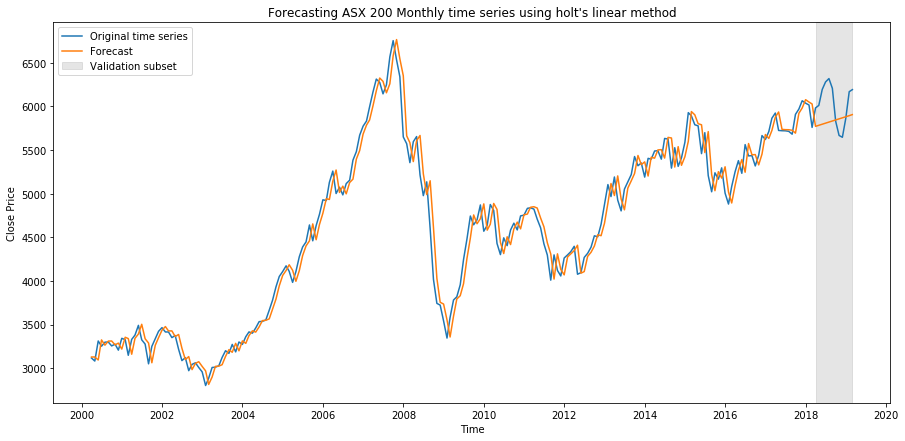

In [11]:
predicted_ts = training_ts.append(predictions)

# Setting figure width and height
rcParams['figure.figsize'] = 15, 7

plt.plot(monthly_ts, label = "Original time series")
plt.plot(predicted_ts, label = "Forecast")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title("Forecasting ASX 200 Monthly time series using holt's linear method")
plt.legend()

In [12]:
# Measuring errors of training subset
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts))
MAE = mean_absolute_error(training_subset, training_ts)
MAPE = np.mean(np.abs((training_subset - training_ts) / training_subset)) * 100

print('Training subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset ->
Root Mean Squared Error (RMSE): 171.4726600461067
Mean Absolute Error (MAE): 133.09661026720664
Mean Absolute Percentage Error (MAPE): 2.9193066286469276


In [13]:
# Measuring errors of validation subset
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions))
MAE = mean_absolute_error(validation_subset, predictions)
MAPE = np.mean(np.abs((validation_subset - predictions) / validation_subset)) * 100

print('Validation subset ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset ->
Root Mean Squared Error (RMSE): 304.3135017292373
Mean Absolute Error (MAE): 265.7955332261059
Mean Absolute Percentage Error (MAPE): 4.318893696423264


### Holt-Winters Method

In [14]:
# For additive seasonality
holt_winters_add = ExponentialSmoothing(training_subset, seasonal_periods = 12, trend = 'add', seasonal = 'add').fit()
training_ts_add = holt_winters_add.fittedvalues

# For multiplicative seasonality
holt_winters_mul = ExponentialSmoothing(training_subset, seasonal_periods = 12, trend = 'add', seasonal = 'mul').fit()
training_ts_mul = holt_winters_mul.fittedvalues

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


In [15]:
# Holt-winters additive seasonality parameters
holt_winters_add.params

{'damping_slope': nan,
 'initial_level': 4566.484400722609,
 'initial_seasons': array([-1349.34327078, -1415.78474898, -1364.72091441, -1384.96950512,
        -1320.85036365, -1363.40978476, -1340.51189915, -1328.58439302,
        -1329.13896769, -1340.11887071, -1336.62542852, -1352.44603163]),
 'initial_slope': 7.93496492523353,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.8421052607986268,
 'smoothing_seasonal': 0.15789473448283736,
 'smoothing_slope': 0.04831968247090076,
 'use_boxcox': False}

In [16]:
## Holt-winters multiplicative seasonality parameters
holt_winters_mul.params

{'damping_slope': nan,
 'initial_level': 4592.288802647548,
 'initial_seasons': array([0.69314699, 0.68364555, 0.67347699, 0.68026041, 0.67871311,
        0.67392213, 0.68296765, 0.67719777, 0.68639964, 0.67733128,
        0.68234897, 0.68380615]),
 'initial_slope': 8.643052089474457,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9999999950005574,
 'smoothing_seasonal': 0.0,
 'smoothing_slope': 0.018456044987313274,
 'use_boxcox': False}

In [17]:
# Forecasting values of next 12 months
predictions_add = holt_winters_add.forecast(12)
predictions_mul = holt_winters_mul.forecast(12)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:322: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  start = self.model._index[-1] + 1
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:323: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  end = self.model._index[-1] + steps
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


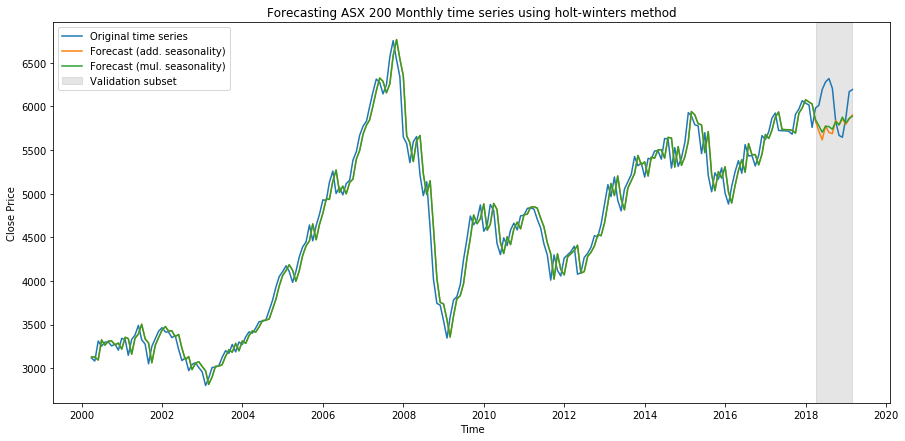

In [18]:
predicted_ts_add = training_ts.append(predictions_add)
predicted_ts_mul = training_ts.append(predictions_mul)

plt.plot(monthly_ts, label = "Original time series")
plt.plot(predicted_ts_add, label = "Forecast (add. seasonality)")
plt.plot(predicted_ts_mul, label = "Forecast (mul. seasonality)")
plt.axvspan(validation_subset.index[0], validation_subset.index[validation_subset.size-1], color='grey', alpha=0.2, label="Validation subset")
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title("Forecasting ASX 200 Monthly time series using holt-winters method")
plt.legend()

In [19]:
# Measuring errors of training subset (additive seasonality)
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts_add))
MAE = mean_absolute_error(training_subset, training_ts_add)
MAPE = np.mean(np.abs((training_subset - training_ts_add) / training_subset)) * 100

print('Training subset (additive seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset (additive seasonality) ->
Root Mean Squared Error (RMSE): 176.84071472456216
Mean Absolute Error (MAE): 133.8296070826578
Mean Absolute Percentage Error (MAPE): 2.9522758666433977


In [20]:
# Measuring errors of validation subset (additive seasonality)
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_add))
MAE = mean_absolute_error(validation_subset, predictions_add)
MAPE = np.mean(np.abs((validation_subset - predictions_add) / validation_subset)) * 100

print('Validation subset (additive seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset (additive seasonality) ->
Root Mean Squared Error (RMSE): 364.53638176823887
Mean Absolute Error (MAE): 306.5366114293416
Mean Absolute Percentage Error (MAPE): 5.017294491615699


In [21]:
# Measuring errors of training subset (multiplicative seasonality)
RMSE = np.sqrt(mean_squared_error(training_subset, training_ts_mul))
MAE = mean_absolute_error(training_subset, training_ts_mul)
MAPE = np.mean(np.abs((training_subset - training_ts_mul) / training_subset)) * 100

print('Training subset (multiplicative seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Training subset (multiplicative seasonality) ->
Root Mean Squared Error (RMSE): 164.94762679168755
Mean Absolute Error (MAE): 128.80671275656525
Mean Absolute Percentage Error (MAPE): 2.8668415839229704


In [22]:
# Measuring errors of validation subset (multiplicative seasonality)
RMSE = np.sqrt(mean_squared_error(validation_subset, predictions_mul))
MAE = mean_absolute_error(validation_subset, predictions_mul)
MAPE = np.mean(np.abs((validation_subset - predictions_mul) / validation_subset)) * 100

print('Validation subset (multiplicative seasonality) ->')
print('Root Mean Squared Error (RMSE):', RMSE)
print('Mean Absolute Error (MAE):', MAE)
print('Mean Absolute Percentage Error (MAPE):', MAPE)

Validation subset (multiplicative seasonality) ->
Root Mean Squared Error (RMSE): 335.6605807691115
Mean Absolute Error (MAE): 283.8755475166334
Mean Absolute Percentage Error (MAPE): 4.595828864708644
